# Inspect ImageNet2012 torchvision Dataset

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import tv_tensors
from torchvision import transforms
from torchvision.transforms import v2  # TODO Verify: not used, v2 is somehow slower in this case

## Inspect Content

Ref for data preparation: https://github.com/pytorch/examples/blob/main/imagenet/extract_ILSVRC.sh

In [2]:
dataset_train = torchvision.datasets.ImageNet(root='../data/imagenet2012/', split='train', transform=torchvision.transforms.ToTensor())
dataset_val = torchvision.datasets.ImageNet(root='../data/imagenet2012/', split='val', transform=torchvision.transforms.ToTensor())

In [3]:
print(f"Len of train dataset: {len(dataset_train)}")
print(f"Len of val dataset: {len(dataset_val)}")
print(f"Number of classes: {len(dataset_train.classes)}")
print(f"\nFirst 10th classes")
for i in range(10):
    print(f"Class {i}: {dataset_train.classes[i]}, ID={dataset_train.class_to_idx[dataset_train.classes[i][0]]}")
print(f"\nSample")
x, y = dataset_train[2]
print(f"Image: {x} ({type(x)=}), hw={x.size}")  # PIL Image with non-fixed size
print(f"Label: {y} ({type(y)=})")

Len of train dataset: 1281167
Len of val dataset: 50000
Number of classes: 1000

First 10th classes
Class 0: ('tench', 'Tinca tinca'), ID=0
Class 1: ('goldfish', 'Carassius auratus'), ID=1
Class 2: ('great white shark', 'white shark', 'man-eater', 'man-eating shark', 'Carcharodon carcharias'), ID=2
Class 3: ('tiger shark', 'Galeocerdo cuvieri'), ID=3
Class 4: ('hammerhead', 'hammerhead shark'), ID=4
Class 5: ('electric ray', 'crampfish', 'numbfish', 'torpedo'), ID=5
Class 6: ('stingray',), ID=6
Class 7: ('cock',), ID=7
Class 8: ('hen',), ID=8
Class 9: ('ostrich', 'Struthio camelus'), ID=9

Sample
Image: tensor([[[0.1216, 0.1412, 0.1373,  ..., 0.2549, 0.3020, 0.2941],
         [0.1373, 0.1529, 0.1529,  ..., 0.2471, 0.2353, 0.2510],
         [0.1529, 0.1529, 0.1451,  ..., 0.1882, 0.2392, 0.2196],
         ...,
         [0.3137, 0.2706, 0.2549,  ..., 0.4196, 0.3020, 0.1294],
         [0.3176, 0.2902, 0.2667,  ..., 0.4157, 0.2980, 0.1294],
         [0.2902, 0.3137, 0.2941,  ..., 0.4039, 0.

In [4]:
torch.manual_seed(1337)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True)
print(f"Example imgs batch: {next(iter(dataloader_train))[0].size()}")
print(f"Example labels batch: {next(iter(dataloader_train))[1].size()}")

Example imgs batch: torch.Size([1, 3, 375, 500])
Example labels batch: torch.Size([1])


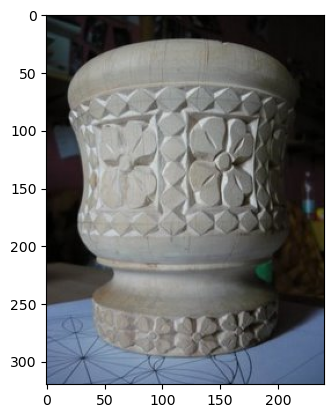

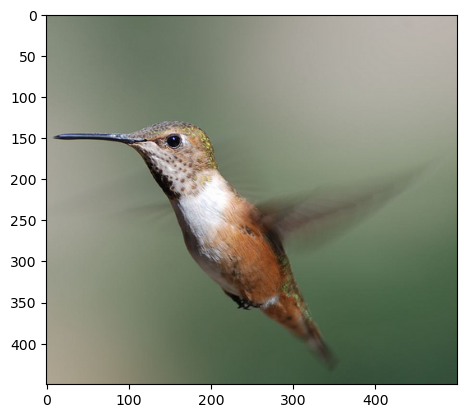

In [5]:
# data get shuffled every time iterator is created

dataiter_train1 = iter(dataloader_train)
img_train1, label_train1 = next(dataiter_train1)
plt.imshow(img_train1[0].permute(1, 2, 0))
plt.show()

dataiter_train2 = iter(dataloader_train)
img_train2, label_train2 = next(dataiter_train2)
plt.imshow(img_train2[0].permute(1, 2, 0))
plt.show()

## Inspect Transforms

In [95]:
dataset_name = 'imagenet2012'
img_h = 256
img_w = 256
imgs_mean = (0.0, 0.0, 0.0)
imgs_std = (1.0, 1.0, 1.0)

brightness = 0.4
contrast = 0.4
saturation = 0.4
hue = 0.1
degrees = 7
scale_min = 0.5
scale_max = 2.0
ratio_min = 3.0 / 4.0
ratio_max = 4.0 / 3.0
flip_p = 0.5

# # No augmentation
# brightness = 0.0
# contrast = 0.0
# saturation = 0.0
# hue = 0.0
# degrees = 0.0
# scale_min = 1.0
# scale_max = 1.0
# ratio_min = 1.0
# ratio_max = 1.0
# flip_p = 0.0

In [4]:
def show_img(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Image, shape={img.size()}")
    plt.show()

### No transform

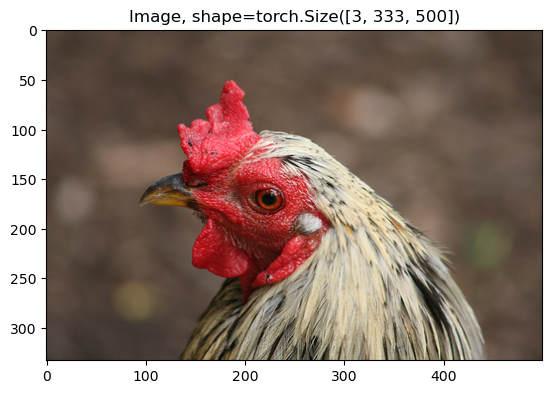

Label: 7


In [5]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
show_img(dataset_train[9999][0])
print("Label:", dataset_train[9999][1])

### Common ImageNet validation transform (center crop)

For timm-aug & tv-aug & simple-aug & no-aug only

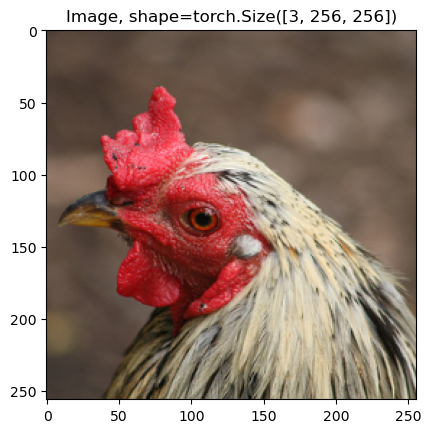

In [11]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train', # split='val'
    transform=v2.Compose([
        v2.ToImage(),
        v2.Resize(size=max(img_h, img_w)),  # OR: v2.Resize(size=max(img_h, img_w) * 232 // 224),  # OR: v2.Resize(size=max(img_h, img_w) * 256 // 224),
        v2.CenterCrop(size=(img_h, img_w)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

### (Archived) Validation transform (pad short edge)

For training augmentation with zoom out

Cons:
- Haven't seen anyone use this kind of transform for image classification val. (Maybe due to too many black pad will affect the pixel value distribution when image get normalized)

/home/alvin/miniconda3/envs/yolo/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


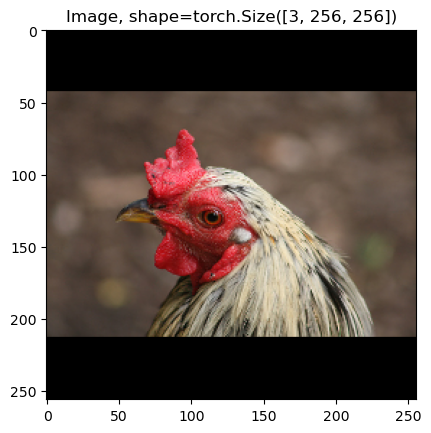

In [9]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train', # split='val'
    transform=v2.Compose([
        v2.ToImage(),
        v2.Resize(size=max(img_h, img_w) - 1, max_size=max(img_h, img_w)),  # max_size must > size
        v2.CenterCrop(size=(img_h, img_w)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

### (Archived) Common ImageNet training transform (simple-aug)

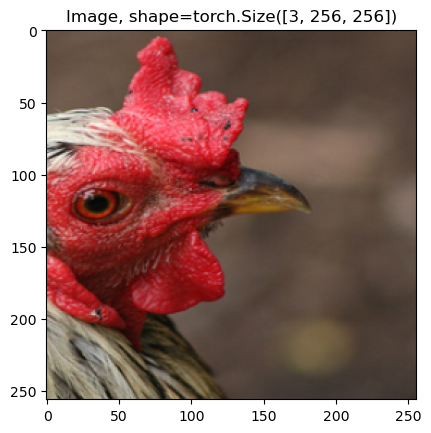

In [764]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        v2.RandomResizedCrop(size=(img_h, img_w), scale=(0.08, 1.0),
                             ratio=((3.0 / 4.0), (4.0 / 3.0)), antialias=True),
        v2.RandomHorizontalFlip(p=flip_p),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

### (Archived) Training transform (type0-aug)

Cons:
- Only zoom in the pad-short-edge val transform
- No rotation

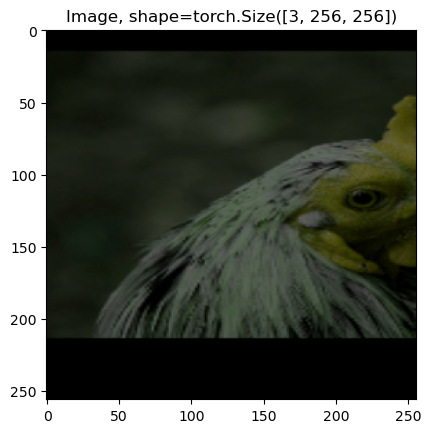

In [39]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        v2.Resize(size=max(img_h, img_w) - 1, max_size=max(img_h, img_w)),  # max_size must > size
        v2.CenterCrop(size=(img_h, img_w)),
        v2.RandomResizedCrop(size=(img_h, img_w), scale=(scale_min ** 2, 1.0),
                             ratio=(scale_min, scale_max), antialias=True),
        v2.RandomHorizontalFlip(p=flip_p),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

### (Archived) Training transform (type1-aug)

Cons:
- Padded edges must have same aspect ratio as the target image size.
- Zoom out scale is for fixed target image size, not the original image.

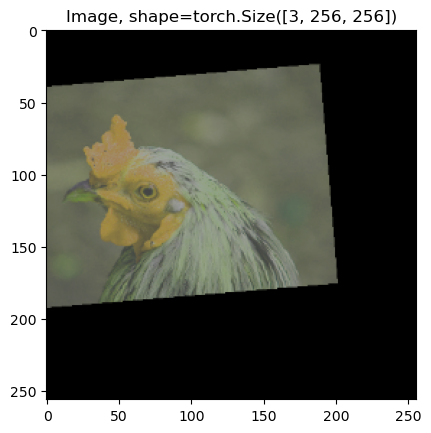

In [762]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        v2.Resize(size=max(img_h, img_w), antialias=True),
        v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        v2.Pad(padding=(int(img_h * (scale_max - 1) / 2), int(img_w * (scale_max - 1) / 2)), fill=0, padding_mode='constant'),
        v2.RandomRotation(degrees=degrees),
        v2.RandomResizedCrop(size=(img_h, img_w), scale=(scale_min ** 2, 1.0), ratio=(ratio_min, ratio_max)),
        v2.RandomHorizontalFlip(p=flip_p),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

### (Archived) Custom training transform (type2-aug)

Cons:
- Padded edges must have same aspect ratio as the original image.
- Not v2 compatible, so cannot be used for object detection.

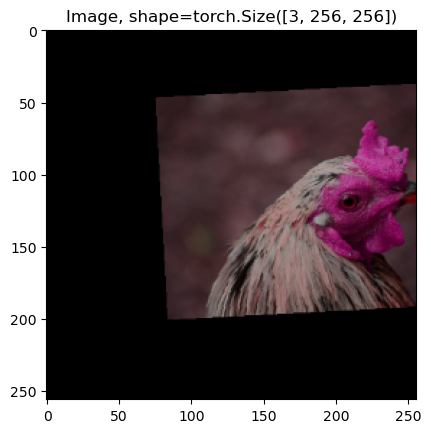

In [773]:
from typing import Any, Callable, Dict, List, Literal, Optional, Sequence, Tuple, Type, Union
import torch.nn as nn
from torchvision.transforms.v2 import functional as F
from torchvision.transforms.v2.functional._utils import _FillType

class ZoomOut(nn.Module):
    def __init__(self,
                 scale: float,
                 fill: Union[_FillType, Dict[Union[Type, str], _FillType]] = 0,
                 padding_mode: Literal["constant", "edge", "reflect", "symmetric"] = "constant",) -> None:
        super().__init__()
        self.scale = scale
        self.fill = fill
        self.padding_mode = padding_mode

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        orig_h, orig_w = img.shape[-2:]
        new_h, new_w = int(orig_h * self.scale), int(orig_w * self.scale)
        padding = ((new_w - orig_w) // 2, (new_h - orig_h) // 2)
        return F.pad(img, padding, self.fill, self.padding_mode)


data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        v2.Resize(size=max(img_h, img_w), antialias=True),
        v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        ZoomOut(scale=scale_max, fill=0, padding_mode='constant'),
        v2.RandomRotation(degrees=degrees),
        v2.RandomResizedCrop(size=(img_h, img_w), scale=(scale_min ** 2, 1.0), ratio=(ratio_min, ratio_max)),
        v2.RandomHorizontalFlip(p=flip_p),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

### (Archived) Training transform (type3-aug)

Cons:
- No random aspect ratio 
- More zoom in, less zoom out
- Scale range might be a bit large
- Cannot achieve no-aug

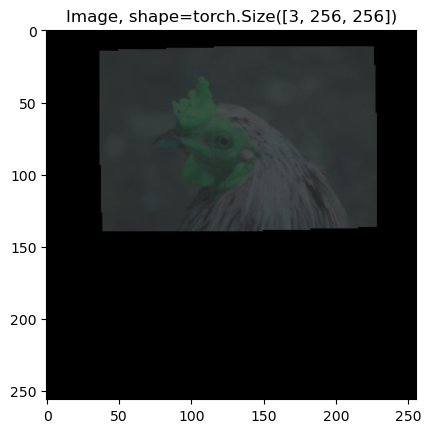

In [782]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        v2.RandomResize(min_size=int(min(img_h, img_w) / scale_max),
                        max_size=int(max(img_h, img_w) / scale_min),
                        antialias=True),
        v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        v2.RandomRotation(degrees=degrees),
        v2.RandomCrop(size=(img_h, img_w), pad_if_needed=True, fill=0, padding_mode='constant'),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

### (Archived) Custom training transform (type4-aug)

Cons:
- Scale range might be a bit large
- Cannot achieve no-aug

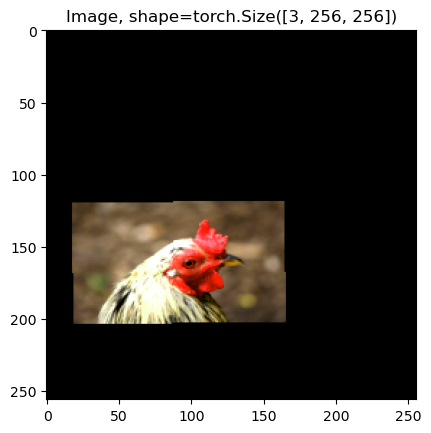

In [121]:
import math
from typing import Any, Callable, Dict, List, Literal, Optional, Sequence, Tuple, Type, Union
from torchvision.transforms.v2 import functional as F, InterpolationMode

class RandomResize(v2.RandomResize):
    def __init__(
        self,
        min_size: int,  # min_size of the longer side
        max_size: int,  # max_size of the longer side
        ratio: Tuple[float, float],
        interpolation: Union[InterpolationMode, int] = InterpolationMode.BILINEAR,
        antialias: Optional[bool] = True,
    ) -> None:
        super().__init__(min_size, max_size, interpolation, antialias)
        self.min_size = min_size
        if max_size == min_size:
            self.max_size = min_size + 1  # randint is [min, max)
        else:
            self.max_size = max_size
        self.ratio = ratio
        self.interpolation = interpolation
        self.antialias = antialias
        self._log_ratio = torch.log(torch.tensor(self.ratio))

    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        long_size = int(torch.randint(self.min_size, self.max_size, ()))
        aspect_ratio = torch.exp(
            torch.empty(1).uniform_(
                self._log_ratio[0],
                self._log_ratio[1],
            )
        ).item()
        aspect_factor = math.sqrt(aspect_ratio)
        orig_h, orig_w = v2._utils.query_size(flat_inputs)
        if orig_h < orig_w:
            size = (int(long_size / orig_w * orig_h / aspect_factor), int(long_size * aspect_factor))
        else:
            size = (int(long_size / aspect_factor), int(long_size / orig_h * orig_w * aspect_factor))
        return dict(size=size)


data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        v2.RandomChoice([
            v2.Compose([
                RandomResize(min_size=int(min(img_h, img_w) / scale_max),
                             max_size=int(max(img_h, img_w) / scale_min),
                             ratio=(ratio_min, ratio_max),
                             antialias=True),
                v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
                v2.RandomCrop(size=(img_h, img_w), pad_if_needed=True, fill=0, padding_mode='constant'),
                v2.RandomRotation(degrees=degrees),
            ]),
            v2.Compose([
                v2.Resize(size=max(img_h, img_w) - 1, max_size=max(img_h, img_w)),  # max_size must > size
                v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
                v2.CenterCrop(size=(img_h, img_w)),
            ])
        ], p=[0.9, 0.1]),
        v2.RandomHorizontalFlip(p=flip_p),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

### (To Test) Training transform (tv-aug)
*From torchvision references/classification/presets.py*

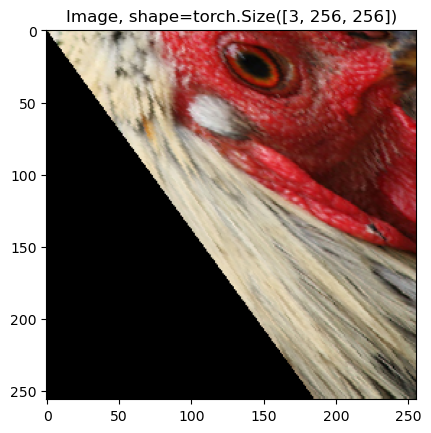

In [34]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        v2.RandomResizedCrop(size=max(img_h, img_w), scale=(0.08, 1.0),
                             ratio=((3.0 / 4.0), (4.0 / 3.0)), antialias=True),
        v2.RandomHorizontalFlip(p=flip_p),
        v2.TrivialAugmentWide(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

### (To Test) Training transform (timm-aug)


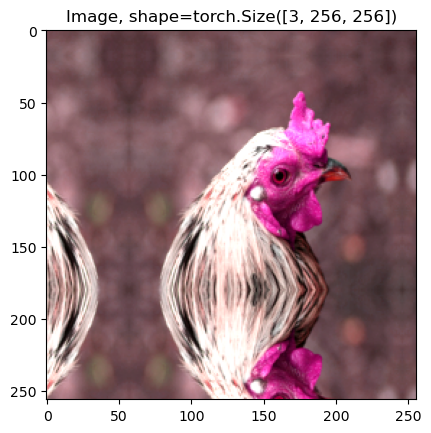

In [120]:
import warnings
import math
from typing import Any, Callable, cast, Dict, List, Literal, Optional, Sequence, Tuple, Type, Union
from torchvision.transforms.v2 import functional as F, InterpolationMode

class RandomResize(v2.RandomResize):
    def __init__(
        self,
        size: Union[int, Sequence[int]],
        scale: Tuple[float, float] = (0.85, 1.05),
        scale_p: float = 0.9,
        ratio: Tuple[float, float] = (0.9, 1.11),
        ratio_p: float = 0.9,
        interpolation: Union[InterpolationMode, int] = InterpolationMode.BILINEAR,
        antialias: Optional[Union[str, bool]] = "warn",
    ) -> None:
        super().__init__(None, None, interpolation, antialias)
        self.size = v2._utils._setup_size(size, error_msg="Please provide only two dimensions (h, w) for size.")
        if not isinstance(scale, Sequence):
            raise TypeError("Scale should be a sequence")
        scale = cast(Tuple[float, float], scale)
        if not isinstance(ratio, Sequence):
            raise TypeError("Ratio should be a sequence")
        ratio = cast(Tuple[float, float], ratio)
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("Scale and ratio should be of kind (min, max)")
        self.scale = scale
        self.ratio = ratio
        self.scale_p = scale_p
        self.ratio_p = ratio_p
        self._log_ratio = torch.log(torch.tensor(ratio))
        self._min_factor = min((1 / self.ratio[0], self.ratio[0],
                                1 / self.ratio[1], self.ratio[1])) / math.sqrt(max(*self.scale))
        if self._min_factor < 0.5:
            raise ValueError("The minimum factor is less than 0.5, please decrease scale_max or adjust ratio.")


    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        img_h, img_w = img_size = v2._utils.query_size(flat_inputs)
        target_h, target_w = self.size
        ratio_h = img_h / target_h
        ratio_w = img_w / target_w
        ratio = min(ratio_h, ratio_w)

        if torch.rand(1) < self.scale_p:
            ratio_factor = torch.empty(1).uniform_(*self.scale)
            ratio_factor = 1.0 / math.sqrt(ratio_factor)
            ratio_factor = (ratio_factor, ratio_factor)
        else:
            ratio_factor = (1.0, 1.0)

        if torch.rand(1) < self.ratio_p:
            aspect_ratio = torch.exp(
                torch.empty(1).uniform_(
                    self._log_ratio[0],
                    self._log_ratio[1],
                )
            ).item()
            aspect_factor = math.sqrt(aspect_ratio)
            ratio_factor = (ratio_factor[0] / aspect_factor, ratio_factor[1] * aspect_factor)

        size = [round(x * f / ratio) for x, f in zip(img_size, ratio_factor)]
        return dict(size=size)



data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        RandomResize(size=(img_h, img_w), scale=(scale_min ** 2, scale_max ** 2),
                     ratio=(ratio_min, ratio_max), antialias=True),
        v2.RandomCrop(size=(img_h, img_w), pad_if_needed=True, padding_mode='reflect'),
        v2.RandomHorizontalFlip(p=flip_p),
        v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])

## Inspect FakeData

In [17]:
n_data = 10
img_h = 256
img_w = 256
n_class = 1000
dataset_fake = torchvision.datasets.FakeData(size=n_data,
                                             image_size=(3, img_h, img_w),
                                             num_classes=n_class,
                                             transform=v2.Compose([v2.ToImage(),
                                                                   v2.ToDtype(torch.float32, scale=True),]))

example_img.shape=torch.Size([3, 256, 256]), example_label=445
example_img.dtype=torch.float32, example_img.min()=tensor(0.), example_img.max()=tensor(1.)


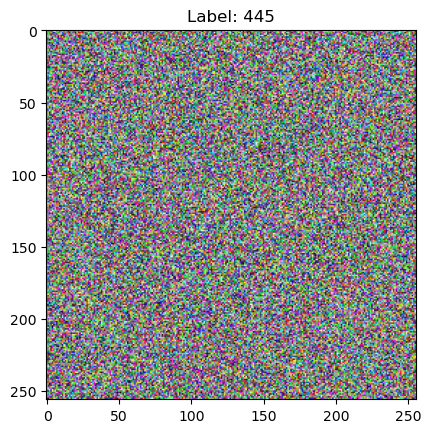

In [18]:
example_img, example_label = dataset_fake[0]
print(f"{example_img.shape=}, {example_label=}")
print(f"{example_img.dtype=}, {example_img.min()=}, {example_img.max()=}")
plt.imshow(example_img.permute(1, 2, 0))
plt.title(f"Label: {example_label}")
plt.show()

In [11]:
dataloader_fake = torch.utils.data.DataLoader(dataset_fake, batch_size=2, shuffle=True)
example_imgs, example_labels = next(iter(dataloader_fake))
print(f"{example_imgs.shape=}, {example_labels.shape=}")

example_imgs.shape=torch.Size([2, 3, 256, 256]), example_labels.shape=torch.Size([2])


In [22]:
dataset_fake_new = torchvision.datasets.FakeData(size=n_data,
                                                 image_size=(3, img_h, img_w),
                                                 num_classes=n_class,
                                                 transform=v2.Compose([v2.ToImage(),
                                                                       v2.ToDtype(torch.float32, scale=True),]))
example_img_new, example_label_new = dataset_fake_new[0]

if (example_img_new == example_img).all() and (example_label_new == example_label):
    print("Fake data is constant")
else:
    print("Fake data is changed randomly")

Fake data is constant


## Inspect Input-Independent Transform using Lambda

In [2]:
dataset_name = 'imagenet2012'
img_h = 256
img_w = 256
imgs_mean = (-0.5, -0.5, -0.5)
imgs_std = (1.0, 1.0, 1.0)

data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train', # split='val'
    transform=v2.Compose([
        v2.Lambda(lambda img: torch.zeros((3, img_h, img_w), dtype=torch.float32)),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
print("Blank img shape:", dataset_train[9999][0].shape, "max:", dataset_train[9999][0].max(), "min:", dataset_train[9999][0].min())
print("Label:", dataset_train[9999][1])

Blank img shape: torch.Size([3, 256, 256]) max: tensor(0.5000) min: tensor(0.5000)
Label: 7
